# (02) Intrinsic analysis of cycling network data

**Input files of this notebook:**
* `../config.yml`
* `../data/osm_{study_area}.graphml`
* `../data/osm_{study_area}_simple.graphml`
* `../data/grid_{study_area}.gpkg`

**Output files of this notebook:**
* `../results/osm_instrinsic_analysis_{study_area}.json`
* `../results/grid_results_intrinsic_{study_area}.pickle`


**Overview**

This notebook analyses the quality of OSM data on cycling infrastructure for a given area. The quality assessment is **intrisic**, i.e. based only on the input data set, and making no use of information external to the data set. (For an extrinsic quality assessment that compares the OSM data set to a reference data set provided by the user, see the next three notebooks `03a`, `03b` and `03c`)

The purpose of the analysis is to assess the *fitness for use* of OSM data for a given area. Outcomes of the analysis can be relevant both for cycling planning and research - particularly for projects that include a network analysis of cycling infrastructure, in which case the topology of the geometries is of particular importance.

Since the assesment do not make use of an external reference dataset as the ground truth, no universal claims of data quality can be made. The idea is much rather to enable the those working with cycling networks based on OSM to assess whether the data is good enough for their particular usecase.

The various steps in the analysis thus attempts to highlight issues that might undermine the quality of analyses based on the data, but leaves the final interpretation of the results to the end user.

The notebook makes use of quality metrics from a range of previous projects investigating OSM/VGI data quality, such as [Antoniou & Skopeliti (2015)](https://www.isprs-ann-photogramm-remote-sens-spatial-inf-sci.net/II-3-W5/345/2015/), [Fonte et al. (2017)](https://www.ubiquitypress.com/site/chapters/e/10.5334/bbf.g/) and [Fester et al. (2020)](https://www.tandfonline.com/doi/full/10.1080/15568318.2018.1519746). 

**For a correct interpretation of some of the metrics for spatial data quality, some familiarity with the area is necessary.**

**Sections:**

1. Load and process data
2. Data completeness
    - Network density (nodes and edges)
3. OSM Tag Analysis
    - Missing Tags
    - Incompatible Tags
    - Tagging Patterns
4. Network Topology
    - Simplification outcomes 
    - Dangling nodes
    - Overshoots 
    - Undershoots
    - Missing intersections
5. Network components
6. Save results
7. *Contributor Data Analysis (work in progress)*
****

## 1. Load and process data

In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import yaml
import matplotlib.pyplot as plt
import contextily as cx
import json
import pickle
from src import evaluation_functions as ef
import numpy as np
from collections import Counter

/Users/anvy/opt/anaconda3/envs/OSMNX/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
/Users/anvy/opt/anaconda3/envs/OSMNX/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### Load settings

In [2]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    missing_tag_dict = parsed_yaml_file['missing_tag_analysis']

    incompatible_tags_dict = parsed_yaml_file['incompatible_tags_analysis']

    cycling_infrastructure_queries = parsed_yaml_file['cycling_infrastructure_queries']
    
print('Settings loaded!')

Settings loaded!


### Load OSM graphs and grid

*(this data is prepared in the 'load_data' notebook)*

In [3]:
# Load simplified and non-simplified graphs
osm_graph = ox.load_graphml(
    f'../data/osm_{study_area}.graphml', 
    edge_dtypes={'cycling_bidirectional': ox.io._convert_bool_string})

osm_simplified_graph = ox.load_graphml(
    f'../data/osm_{study_area}_simple.graphml', 
    edge_dtypes={'cycling_bidirectional': ox.io._convert_bool_string})

# Convert to nodes and edges
nodes, edges = ox.graph_to_gdfs(osm_graph)
simplified_nodes, simplified_edges = ox.graph_to_gdfs(osm_simplified_graph)

# convert lengths to float
simplified_edges["infrastructure_length"] = simplified_edges["infrastructure_length"].astype(float)

# Load grid
grid = gpd.read_file(f'../data/grid_{study_area}.gpkg')

grid_ids = grid.grid_id.to_list()

#Joining grid cell id to network elements and counting features in each grid
s_edges_join = gpd.overlay(simplified_edges, grid, how ='intersection')
edges_join = gpd.overlay(edges, grid, how='intersection')

s_nodes_join = gpd.overlay(simplified_nodes, grid, how ='intersection')
nodes_join = gpd.overlay(nodes, grid, how='intersection')

s_edges_join['length'] = s_edges_join['geometry'].length
s_edges_join['infrastructure_length'] = s_edges_join.apply(
    lambda x: ef.measure_infrastructure_length(
        edge = x.geometry, 
        geometry_type=x.cycling_geometries, 
        bidirectional=x.cycling_bidirectional, 
        cycling_infrastructure=x.cycling_infrastructure), 
    axis=1)

# Count features in each grid cell
all_data = [edges_join, nodes_join, s_edges_join, s_nodes_join]
labels = ['edges','nodes','simplified_edges','simplified_nodes']

for data, label in zip(all_data, labels):

    df = ef.count_features_in_grid(data,label)

    grid = grid.merge(df, on='grid_id', how = 'left')

print('Data loaded!')

Data loaded!


__________________


## 2. Data completeness

### Network Density

#### Why?

Network density without comparing to a reference dataset does not in itself indicate spatial data quality. For anyone familiar with the study area, network density can however indicate whether parts of the area appear to be under- or overmapped, and is thus included here.

#### How?

The density here is not based on the geometric length of edges, but instead on the computed length of the infrastructure. For example, a 100 meter long bidirectional path contributes with 200 meters of cycling infrastructure. With `compute_network_density`, we compute the number of elements (nodes; danling nodes; and total infrastructure length) per unit area. The density is computed twice: first for the study area ("global density"), then for each of the grid cells ("local density").

#### What could it mean?

Since the analysis we conduct here is intrinsic, i.e. it makes no use of external information, we cannot know whether a low density value is due to incomplete mapping, or due to actual lack of infrastructure in the area. However, a comparison of the grid cell density values can provide some insights, for example:
* lower-than-average infrastructure density indicates a locally sparser network
* higher-than-average node density indicates a that there are relatively many intersections in the grid cell
* higher-than-average dangling node density indicates that there are relatively many dead ends in the grid cell


For the entire study area, there are:
- 5877.13 meters of cycling infrastructure per square km
- 26.14 nodes in the cycling network per square km
- 9.89 dangling nodes in the cycling network per square km


<AxesSubplot:>

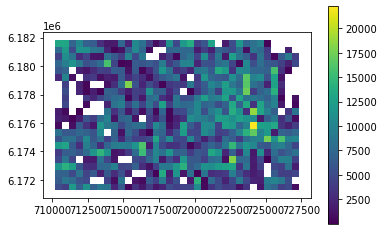

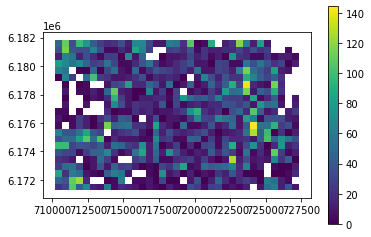

In [14]:
# Entire study area
edge_density, node_density, dangling_node_density = ef.compute_network_density(
    (simplified_edges, simplified_nodes),
    grid.unary_union.area, 
    return_dangling_nodes=True)

density_results = {}
density_results['edge_density'] = edge_density
density_results['node_density'] = node_density
density_results['dangling_node_density'] = dangling_node_density

print(f'For the entire study area, there are:')
print(f'- {edge_density:.2f} meters of cycling infrastructure per square km')
print(f'- {node_density:.2f} nodes in the cycling network per square km')
print(f'- {dangling_node_density:.2f} dangling nodes in the cycling network per square km')

# Per grid cell
results_dict = {}
data = (s_edges_join, s_nodes_join)

[ef.run_grid_analysis(
    grid_id, data, 
    results_dict, 
    ef.compute_network_density, 
    grid['geometry'].loc[grid.grid_id==0].area[0]) 
for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id', 0:'edge_density',1:'node_density'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

# TODO: Format plotting
grid.plot(column='edge_density', legend=True)
grid.plot(column='node_density', legend=True)
# TO DO grid.plot(column='dangling_node_density', legend=True);

______________________

## 3. OSM tag analysis

For many practical and research purposes, we are interested in more information than the mere presence/absence of cycling infrastructure. Information about e.g. the width of the infrastructure, speed limits, street lights etc. can be of high relevance, for example when evaluating the bikefriendliness of an area or individual network segment. The presence of these tags (describing attributes of the cycling infrastructure) is however highly uneven in OSM, which poses a barrier to evaluations of bikeability and traffic stress. Likewise, the lack of restrictions on how OSM features can be tagged often result in conflicting tags, which undermines the evaluation of cycling conditions.

Here, we analyse:

1. **Missing tags** - to what extent are tags indicated in the data set?
2. **Incompatible tags** - in what cases are edges labelled with two or more contradictory tags?
3. **Tagging patterns** - is there a spatial variation to what tags are being used in OSM to describe cycling infrastructure?

Note that for the evaluation of tags, the non-simplified edges should be used to avoid issues with tags that have been aggregated in the simplification process.

### Missing tags

#### Why?

The information that is required or desirable to obtain from the OSM tags will depend on the use case - for example, the tag `lit` for a project looking at light conditions on cycle paths. The workflow below allows to quickly analyse the percentage of network edges that have a value for the tag of interest. 

#### How?

We analyse all tags of interest as defined in the `missing_tag_analysis` section of `config.yml`. For each of these tags, we use `analyse_missing_tags` to compute the total number and the percentage of edges that have a corresponding tag value.

#### What could it mean?

On study area level, a higher percentage of existing tag values in principle indicates a higher quality of the data set; however, note that this is different to an estimation of whether the existing tag values are truthful. On grid cell level, lower-than-average percentages for existing tag values can indicate a more poorly mapped area. However, note that the percentages are less informative for grid cells with a low number of edges: for example, if a cell contains one single edge that has a tag value for `lit`, the percentage of existing tag values is 100% - but given that there is only 1 data point, this is less informative than, say, a value of 80% for a cell that contains 200 edges.



In [4]:
print(f'Analysing tags describing:')
[print(key) for key, _ in missing_tag_dict.items()]

existing_tags_results = ef.analyse_missing_tags(edges, missing_tag_dict)

for key, value in existing_tags_results.items():
    print(f'In the entire dataset, {value} edges or {value/len(edges)*100:.2f} % have information about: {key}')

results_dict = {}
[ef.run_grid_analysis(grid_id, edges_join, results_dict, ef.analyse_missing_tags, missing_tag_dict) for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')
cols = results_df.columns
new_cols = ['existing_tags_'+c for c in cols]
results_df.columns = new_cols
results_df['existing_tags_sum'] = results_df[new_cols].sum(axis=1)
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id'}, inplace=True)

grid = grid.merge(results_df, on='grid_id', how='left')

for c in new_cols:
    grid[c+'_pct'] = round(grid[c] / grid.count_edges * 100,2)

existing_tags_pct = {}

for k, v in existing_tags_results.items():
    existing_tags_pct[k+'_pct'] = v / len(edges) * 100

existing_tags_results = dict(existing_tags_results, **existing_tags_pct)

Analysing tags describing:
surface
width
speedlimit
lit
In the entire dataset, 1288 edges or 4.16 % have information about: surface
In the entire dataset, 644 edges or 2.08 % have information about: width
In the entire dataset, 16556 edges or 53.49 % have information about: speedlimit
In the entire dataset, 24132 edges or 77.97 % have information about: lit


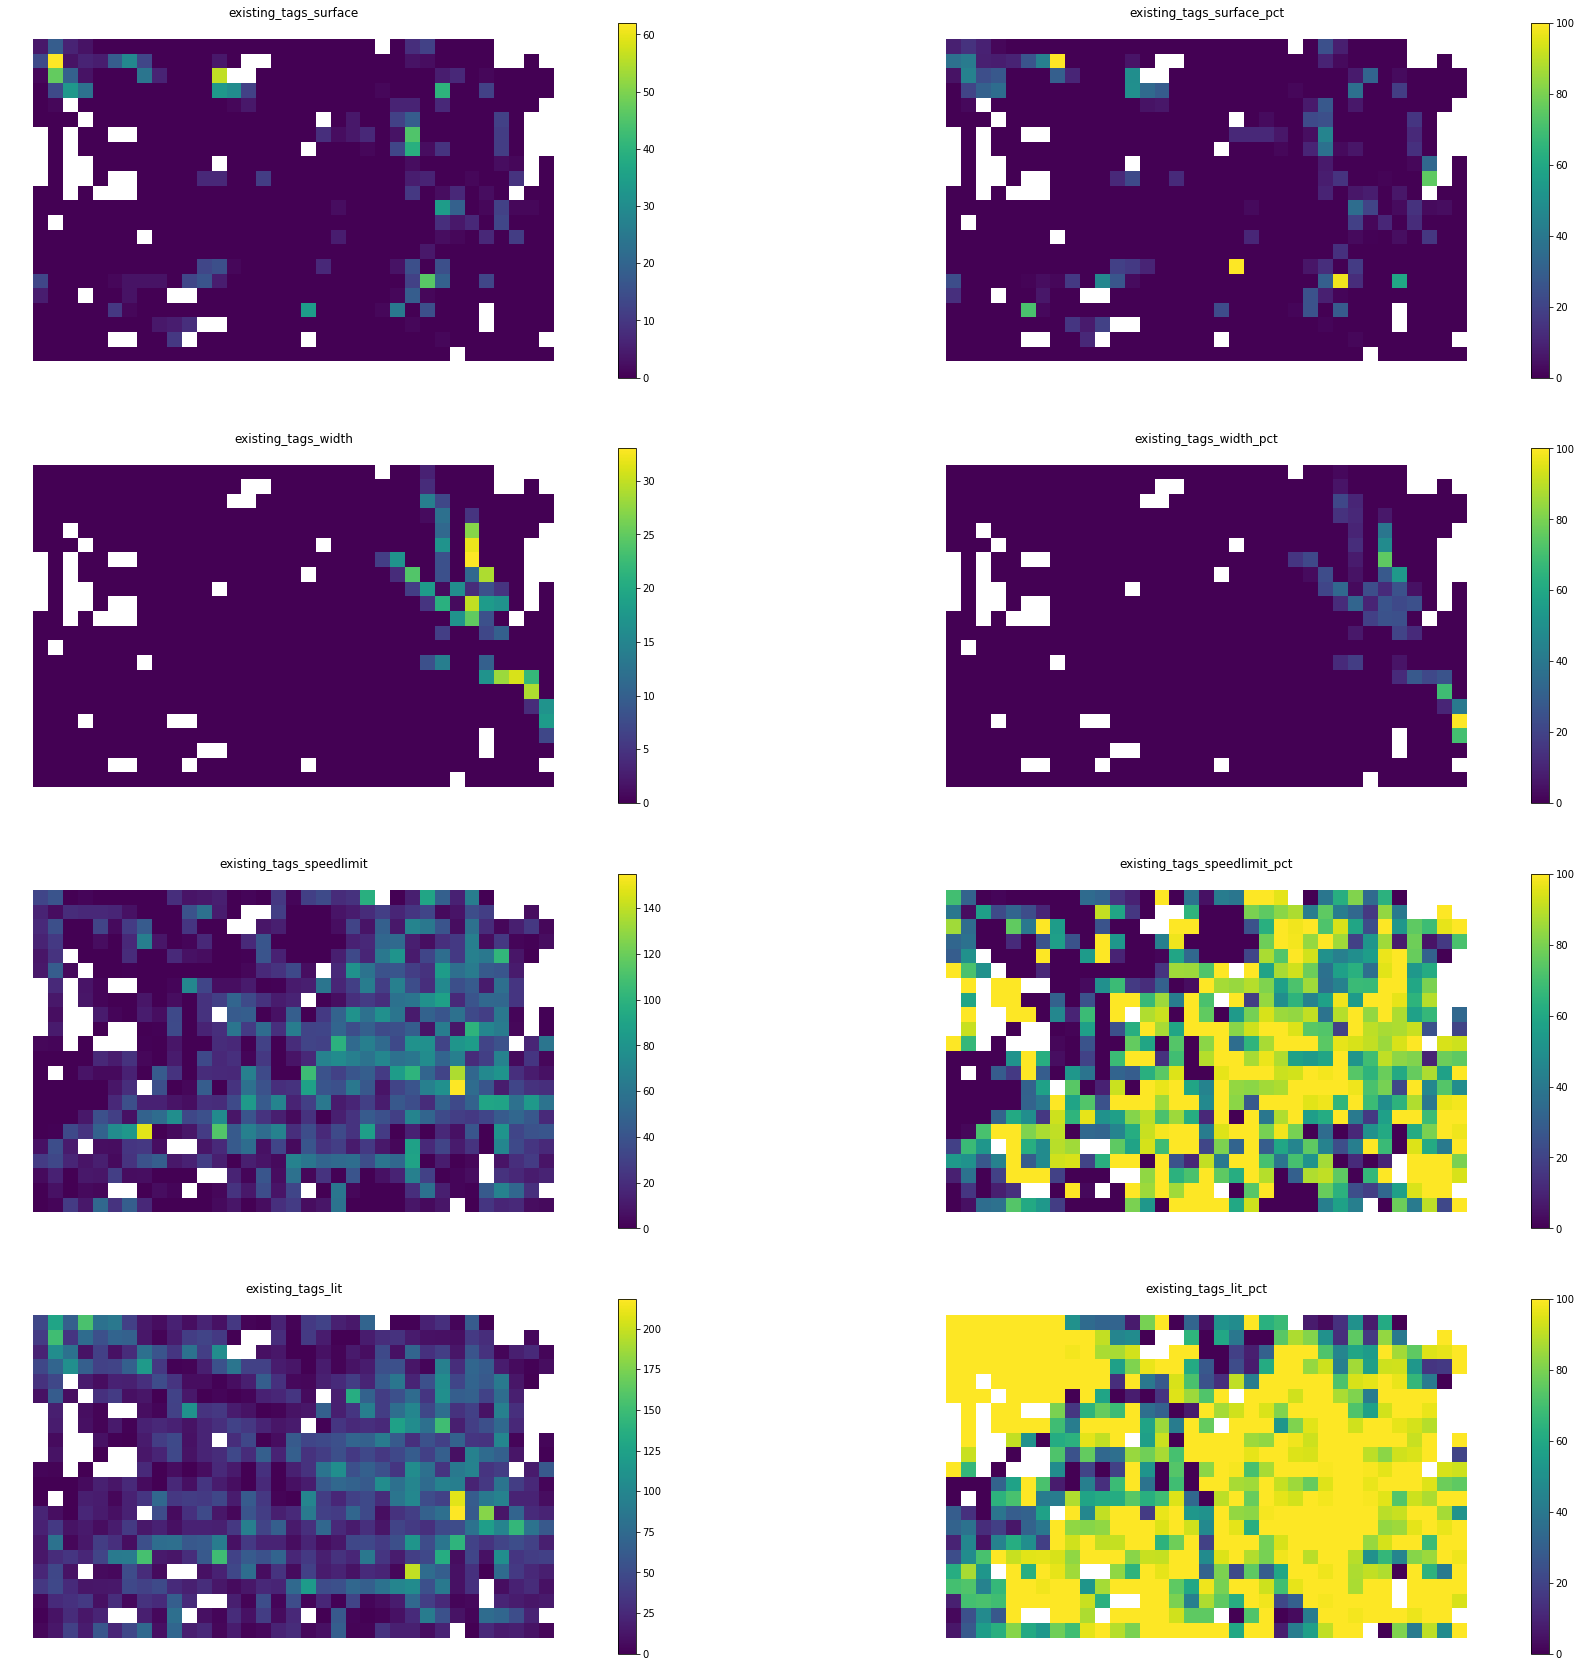

In [5]:
#  TODO: Format plotting 
fig, axes = plt.subplots(nrows=len(new_cols), ncols=2, figsize=(30,30))

for i,c in enumerate(new_cols):
    ax1 = axes[i][0]
    ax2 = axes[i][1]
    grid.plot(ax=ax1, column=c, legend=True)
    grid.plot(ax=ax2, column=c+'_pct', legend=True)

    ax1.set_axis_off()
    ax2.set_axis_off()
    ax1.set_title(c)
    ax2.set_title(c+'_pct')

## ANVY TO DO: set plots to RELATIVE values!!! and have 1 plot for each 0.2 percentile

### Incompatible tags

#### Why?

Given that the tags in OSM data lack coherency at times and there are no restrictions in the tagging process (cf. [Barron et al., 2014](https://onlinelibrary.wiley.com/doi/10.1111/tgis.12073)), incompatible tags might be present in the data set. For example, an edge might be tagged with the following two contradicting key-value pairs: `cycling_infrastructure = yes` and `bicycle = no`. 

#### How?

In the `config.yml` file we have defined a list of incompatible key-value pairs for tags in the `incompatible_tags_analysis`. Since there is no limitation as to which tags a data set could potentially contain, our list is, by definition, non-exhaustive, and can be adjusted by the user. In the section below, we run `check_incompatible_tags`, which identifies all incompatibility instances for a given area, first for study area level and then for grid cell level.

#### What could it mean?

Incompatible tags are an undesired feature of the data set, and render the corresponding data points invalid; there is no straightforward way to resolve the arising issues automatically, making it necessary to either correct the tag manually or to exclude the data point from the data set. A higher-than-average number of incompatible tags in a grid cell suggests local mapping issues.

In [6]:
incompatible_tags_results = ef.check_incompatible_tags(edges, incompatible_tags_dict)

print(f'In the entire dataset, there are {sum(incompatible_tags_results.values())} incompatible tag combinations (of those defined)')

results_dict = {}
[ef.run_grid_analysis(
    grid_id, 
    edges_join, 
    results_dict, 
    ef.check_incompatible_tags, 
    incompatible_tags_dict) 
for grid_id in grid_ids];

results_df = pd.DataFrame.from_dict(results_dict, orient='index')

cols = results_df.columns
new_cols = ['incompatible_tags_'+c for c in cols]
results_df.columns = new_cols
results_df['incompatible_tags_sum'] = results_df[new_cols].sum(axis=1)
results_df.reset_index(inplace=True)
results_df.rename(columns={'index':'grid_id'}, inplace=True)
grid = grid.merge(results_df, on='grid_id', how='left')


In the entire dataset, there are 4 incompatible tag combinations (of those defined)


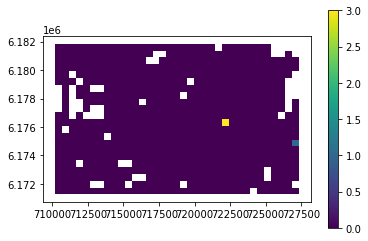

In [7]:
# # TODO: Format plotting -
for key in incompatible_tags_results.keys():
    grid.plot(column='incompatible_tags_'+key, legend=True)

### Tagging patterns

#### Why?

Identifying cycling infrastructure in OSM can be tricky, due to the many different ways in which the presence of cycling infrastructure can be indicated. The [OSM Wiki](https://wiki.openstreetmap.org/wiki/Main_Page) is a great resource for recommendations for how OSM features should be tagged, but some inconsistencies and local variations do remain. The analysis of tagging patterns allows to visually explore some of the potential inconsistencies.

Regardless of how the cycling infrastructure is defined, examining which tags contribute to which parts of the cycling network allows to visually examine patterns in tagging methods. It also allows to estimate whether some elements of the query will lead to the inclusion of too many or too few features.

Likewise, 'double tagging' where several differnet tags have been used to indicate cycling infrastructure can lead to mis-classifications of the data. In some instances, such as 'cycleway:right' and 'cycleway:left', having data for both tags is valid, but other combinations such as 'cycleway'='track' and 'cycleway:left=lane' gives an ambiguouos picture of what type of cycling infrastructure is present.

For this reason, identifying features that are included in more than one of the queries defining cycling infrastructure can indicate issues with the tagging quality.

#### How?

In the section below, we plot subsets of the OSM data set for each of the queries listed in `cycling_infrastructure_queries`, as defined in the `config.yml` file. The subset defined by a query is the set of edges for which this query is True. Since several queries can be True for the same edge, the subsets can overlap. 

#### What could it mean?

##### ANVY TO DO: ADD INTERPRETATION AFTER FIXING PLOTS

##### ANVY TO DO: FIX PLOTS

**Visualising how different elements of the network is tagged:**

In [8]:
edges['tagging_type'] = ''

for k, q in cycling_infrastructure_queries.items():

    try:
        ox_filtered = edges.query(q)

    except Exception:
        print('Exception occured when quering with:', q)
    
    edges.loc[ox_filtered.index, 'tagging_type'] = edges.loc[ox_filtered.index, 'tagging_type'].astype(str) + str(k)

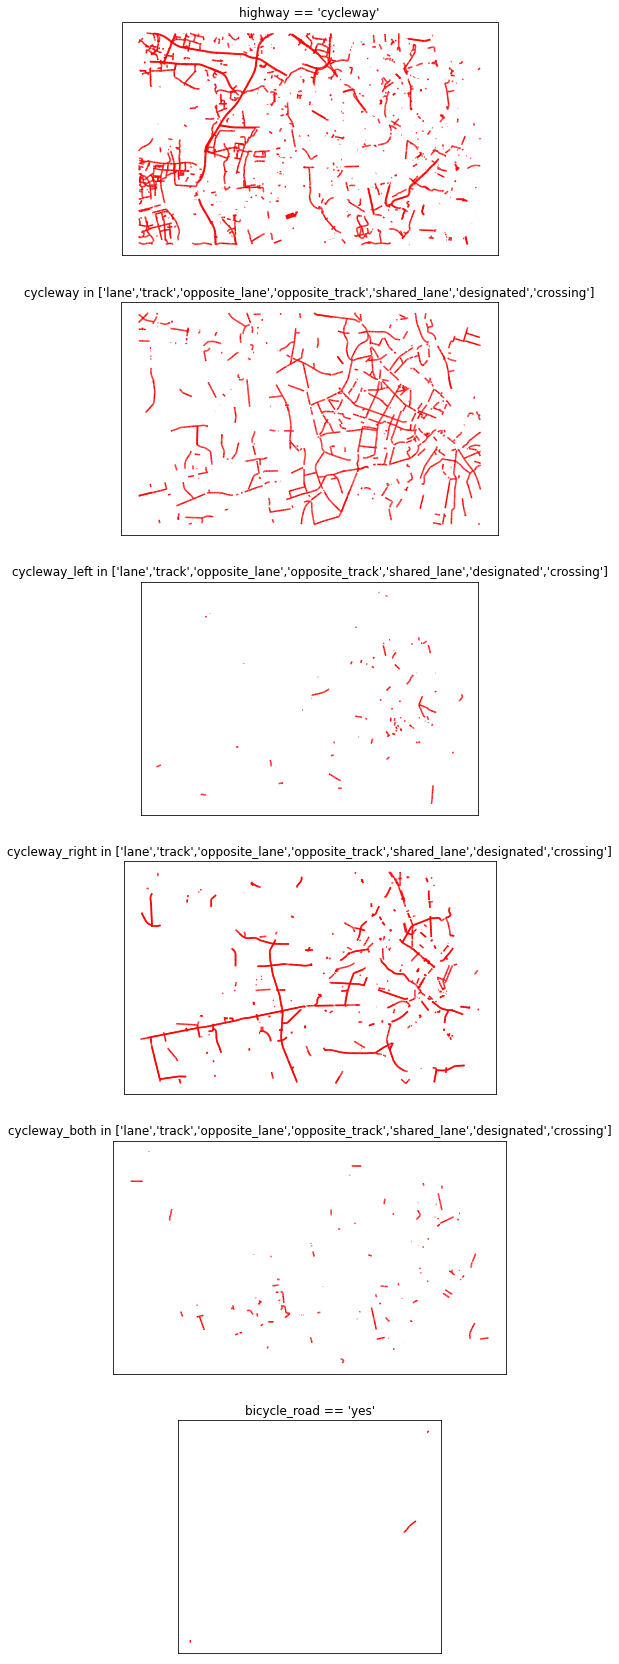

In [10]:
# TODO: fix plots!

# These plots include all edges where the query is true - also those that are true for more than one query
fig, axes = plt.subplots(nrows=len(cycling_infrastructure_queries), ncols=1, figsize=(30,30))

axes = axes.flatten()

for k, q in cycling_infrastructure_queries.items():
    
    ax = axes[k-1]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    edges.loc[edges['tagging_type'].str.contains(str(k))].plot(ax=ax, color='red')

    ax.set_title(q)

    cx.add_basemap(
        ax=ax, 
        crs=simplified_edges.crs, 
        source=cx.providers.CyclOSM,
    )

**Visualising where cycling infrastructure have been tagged in several, potentially competing, ways:**

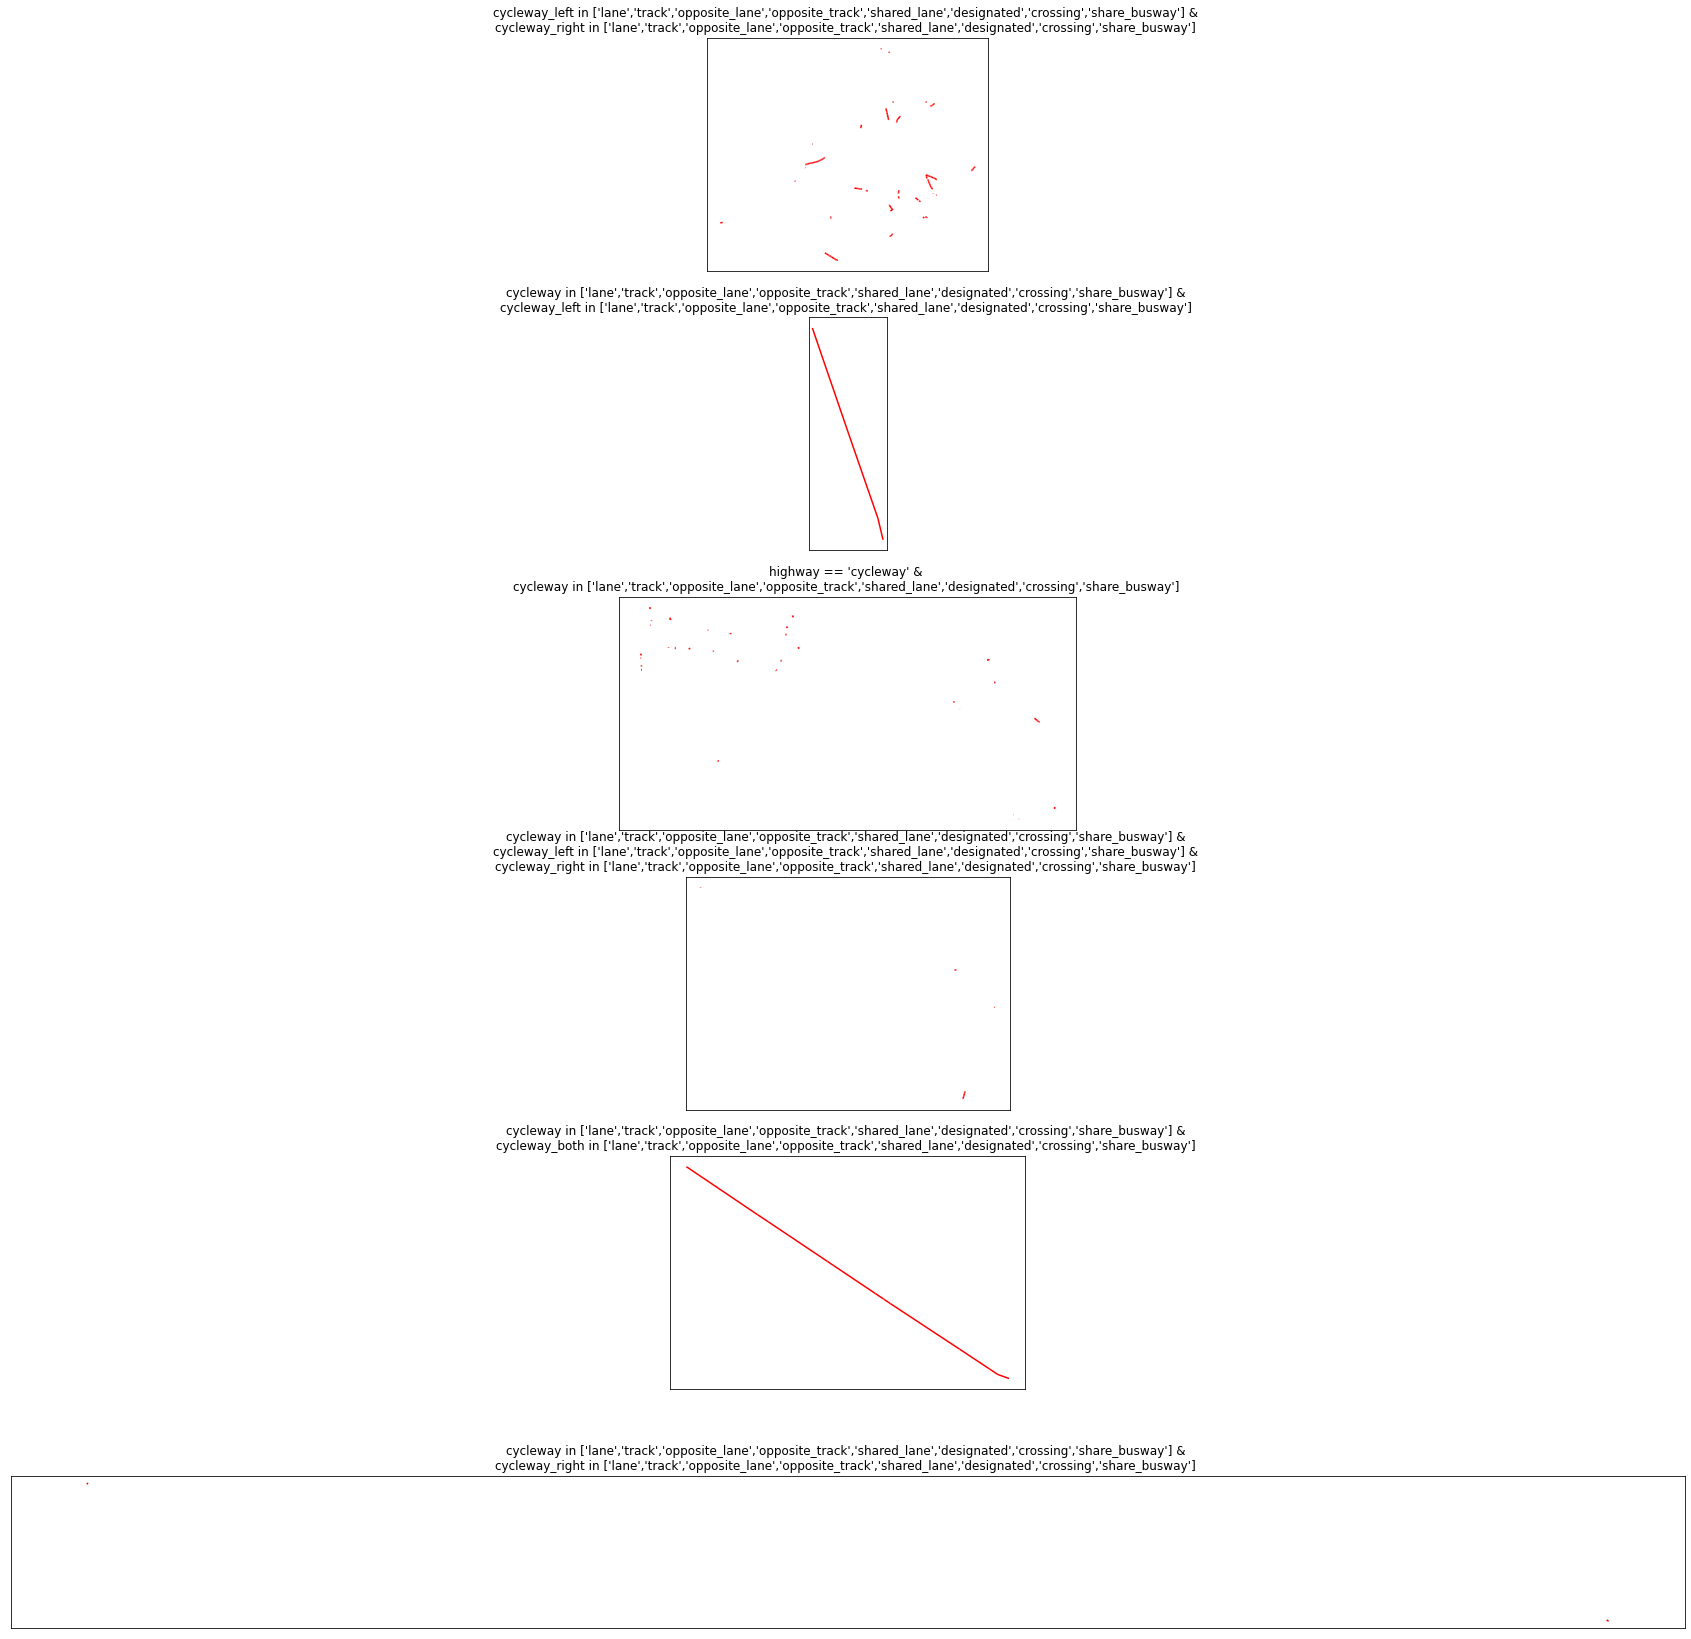

In [ ]:
# TODO: fix plots!

# Plot all edges where tagging_type is more than one letter
tagging_combinations = list(edges.tagging_type.unique())
tagging_combinations = [x for x in tagging_combinations if len(x) > 1]

fig, axes = plt.subplots(nrows=len(tagging_combinations), ncols=1, figsize=(30,30))

axes = axes.flatten()

for i, t in enumerate(tagging_combinations):

    ax = axes[i]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    edges.loc[edges['tagging_type']==t].plot(ax=ax, color='red')

    # Get queries corresponding to k
    title = ''
    for value in t:
        query = cycling_infrastructure_queries[int(value)]
        title = title + str(query) + ' & \n'
    
    title = title.rsplit('&', 1)[0]
    
    ax.set_title(title)


______________________

## 4. Network topology

This section explores the geometric and topological features of the data.

These are, for example, network density, disconnected components, dangling (degree one) nodes; it also includes exploring whether there are nodes in close proximity, that do not share an edge - a potential sign of edge undershoots - or if there are intersecting edges without a node at the intersection, which might indicate a digitizing error that will distort any attempts at routing on the network.

It is important to note that due to the fragmented nature of most networks of cycling infrastructure, many metrics, such as missing links or network gaps, simply reflect the true extent of the infrastructure ([Natera Orozco et al., 2020](https://onlinelibrary.wiley.com/doi/pdfdirect/10.1111/gean.12324)). This is different for car networks, where e.g. disconnected components could more readily be interpreted as a data quality issue.

Therefore, our analysis only takes very small network gaps into account as potential data quality issues.

**Subsections:**
1. Simplification outcomes
2. Network density (nodes and edges)
3. Dangling nodes
4. Network components
5. Snapping issues


### Simplification & graph conversion outcome

When converting a set of geocoded linestrings (polygonal chains) to graph format, not all vertices (nodes) are of equal meaning. For geometry of the infrastructural element, all nodes are needed as an ordered list. For the topology of the network, however, only those nodes that are endpoints or intersection points with other edges are needed, while all other (so-called "interstitial") nodes do not add any information. In order to compare the structure and true ratio between nodes and edges in a network, a simplified network representation which only includes nodes at endpoints and intersections, or where the value of important attributes changes, is required. Therefore, in the notebook `01_load_data` we already "simplified" the cycling network by removing all interstitial nodes from the graph object (retaining, however, the complete node lists in the geometry attribute of each edge). An additional advantage of simplifying the network is the resulting substantial reduction of the number of nodes and edges, which makes computational routines much faster.

#### Why?

Comparing the node degree distribution for the networks before and after simplification is a quick sanity check for the simplification routine. Typically, the big majority of nodes in the non-simplified network will be of degree two; in the simplified network, however, most nodes will have degrees other than two. Degree two nodes are retained in only two cases: if they represent a connection point between two different types of infrastructure; or if they are needed in order to avoid self-loops (edges whose start and end points are identical) or multiple edges between the same pair of nodes. 

As part of the simplification routine, in cases where there are several edges between the same pair of nodes ("parallel edges"), only one of the edges is retained. Within the routine, we count how many edges are removed in this way. 

#### How?

Below, we print out both the node degree distributions before and after simplification, and the information on parallel edges removed by the simplificaton routine.

#### What could it mean?

Typically, the node degree distribution will go from high (before simplification) to low (after simplification) counts of degree two nodes, while it will not change for all other degrees (1, or 3 and higher). Further, the total number of nodes will see a strong decline. If the simplified graph still maintains a relatively high number of degree two nodes, or if the number of nodes with other degrees changes after the simplification, this might point to issues either with the graph conversion or with the simplification process.

The instances where parallel edges between the same pair of nodes were removed are a potential data quality issue of "overmapping", where one infrastructure element is represented by several identical or nearly identical features. Alternatively, if many parallel edges are present in the data set, this could point to a problem in the conversion from linestrings to graph format, for example in how nodes are defined. 

Node degree counts before simplification: Counter({2: 26540, 1: 1794, 3: 1789, 4: 712, 5: 28, 7: 1, 6: 1})
Node degree counts after simplification: Counter({1: 1794, 3: 1789, 4: 712, 2: 416, 5: 28, 7: 1, 6: 1})


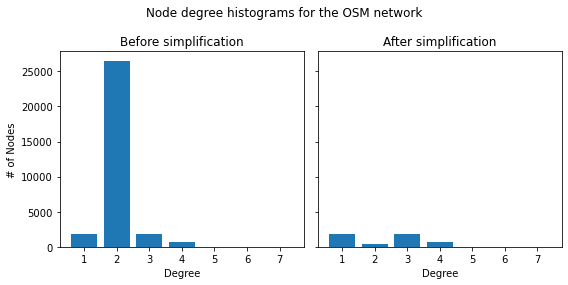

In [26]:
# NODE DEGREE DISTRIBUTION

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey = True)

degree_sequence_before = sorted((d for n, d in osm_graph.degree()), reverse=True)
degree_sequence_after = sorted((d for n, d in osm_simplified_graph.degree()), reverse=True)

ax[0].bar(*np.unique(degree_sequence_before, return_counts=True))
ax[0].set_title("Before simplification")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("# of Nodes")

ax[1].bar(*np.unique(degree_sequence_after, return_counts=True))
ax[1].set_title("After simplification")
ax[1].set_xlabel("Degree")

plt.suptitle("Node degree histograms for the OSM network")

fig.tight_layout()

print("Node degree counts before simplification:", Counter(degree_sequence_before))
print("Node degree counts after simplification:", Counter(degree_sequence_after))

plt.show()

In [40]:
### TO DO ANVY: INSERT SIMPLIFICATION ROUTINE PLOT

### Dangling nodes

#### Why?

Dangling nodes are nodes of degree one - in other words, nodes that have only one single edge attached to them. Most networks will naturally contain a number of dangling nodes. Dangling nodes can occur at actual dead-ends (representing a cul-de-sac), at the endpoints of certain features (e.g. when a bicycle path ends in the middle of a street), or in case of over/undershoots (as described in detail in the next section). The number of dangling nodes in a network does to some extent also depend on the digitization method, as shown in the illustration below. 

Therefore, the presence of dangling nodes is in itself not a sign of low data quality. However, a high number of dangling nodes in an area that is not known for suffering from many dead-ends can indicate digitization errors and problems with edge over/undershoots.

<img src='../images/dangling_nodes_illustration.png' height=200 />  <img src='../images/no_dangling_nodes_illustration.png' height=200 />

*Dangling nodes occur where road features end (left), but when separate features are joined at the end (right), there will be no dangling nodes*

#### How?

Below, we obtain a list of all dangling nodes with the help of `get_dangling_nodes`. Then, we plot the network with all its nodes. The dangling nodes are shown in red, all other nodes are shown in black.

#### What could it mean?

We recommend a visual analysis in order to interpret the spatial distribution of dangling nodes, with particular attention to areas of high dangling node density. It is important to understand where dangling nodes come from: are they actual dead-ends or digitization errors (e.g. over/undershoots)? A higher number of digitization errors points to a lower quality of the data.

In [1]:
## TO DO ANVY: MAKE FOLIUM PLOT OF THIS (TO ZOOM IN)

# Compute number of dangling nodes - and plot them
dangling_nodes = ef.get_dangling_nodes(simplified_edges, simplified_nodes)

fig, ax = plt.subplots(1, figsize=(20,20))

simplified_edges.plot(ax=ax, color='black', linewidth=0.5)
simplified_nodes.plot(ax=ax, color='black', markersize=5)
dangling_nodes.plot(ax=ax, color='red', markersize=20)

cx.add_basemap(
        ax, 
        crs=simplified_edges.crs, 
        source=cx.providers.CartoDB.Voyager
    )

NameError: name 'ef' is not defined

### Under/overshoots 

#### Why?

When two nodes in a simplified network are placed within a distance of a few meters, but do not share a common edge, we often have a case of an edge over/undershoot or another digitizing error. An overshoot occurs when two features meet and one of them extends beyond the other. An undershoot occurs when two features are supposed to meet, but instead are just in close proximity to each other. See the image below for an illustration of an overshoot (left) and an undershoot (right). For a more detailed explanation of over/undershoots, see the [GIS Lounge website](https://www.gislounge.com/digitizing-errors-in-gis/).

<img src='../images/overshoot_illustration.png' height=200 />  <img src='../images/undershoot_illustration.png' height=200 />

*Overshoots refer to situations where a line feature extends too far beyond at intersecting line, rather than ending at the intersection (left).* 
*Undershoots happen when two line features are not properly joined, for example at intersection (right)*

#### How?

**Overshoots:** First, we define the `length_tolerance` (in meters). The default value is set to `length_tolerance = 3` and can be changed in the code snippet below. Then, with `find_overshoots`, we identify all network edges that have a dangling node attached to them and that have a maximum length of `length_tolerance`, as overshoots, and plot the results.

**Undershoots**: First, we define the `length_tolerance` (in meters). The default value is set to `length_tolerance = 3` and can be changed in the code snippet below. Then, with `find_undershoots`, we identify all pairs of dangling nodes that have a maximum of `length_tolerance` distance between them, as undershoots, and plot the results.

The workflow for over/undershoot detection below is based on [Barron et al., 2014](https://onlinelibrary.wiley.com/doi/10.1111/tgis.12073).

#### What could it mean?

Note that over/undershoots are not necessarily always a data quality issue - they might be instead an accurate representation of the network conditions or of the digitization strategy (for example, a cycle path might end abruptly soon after a turn, which results in an overshoot; protected cycle paths are often digitized in OSM as interrupted at intersections, which results in intersection "undershoots") 

The interpretation of the impact of over/undershoots on data quality is context-dependent. For certain applications, such as routings, overshoots do not present a particular challenge; they can, however, pose an issue for other applications such as network analysis, given that they skew the network structure.  Undershoots, on the contrary, are a serious problem for routing applications, especially if only cycling infrastructure is considered; they also pose a problem for network analysis, for example for any path-based metric, such as most centrality measures (e.g. betweenness centrality). 

#### Overshoots

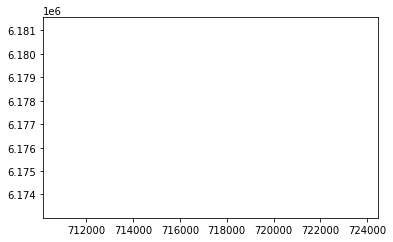

In [8]:
length_tolerance = 3
overshoots = ef.find_overshoots(dangling_nodes, simplified_edges, length_tolerance, return_overshoot_edges=True)

overshoots.plot();
# TODO: Make Folium plot - should be possible to zoom in!

print(f'{len(overshoots)} potential overshoots were identified')

#### Undershoots

In [2]:
length_tolerance = 3
undershoot_dict, undershoot_nodes = ef.find_undershoots(
    dangling_nodes, 
    simplified_edges, 
    length_tolerance, 
    'edge_id', 
    return_undershoot_nodes=True)

undershoot_nodes.plot();

print(f'{len(undershoot_nodes)} potential undershoots were identified')

### TODO ANVY: make folium plt

NameError: name 'ef' is not defined

### Missing nodes at edge intersections

#### Why?

When two edges intersect without having a node at the intersection - and if neither edges are tagged as a brige or a tunnel - we have a clear indication of a topology error. 

#### How?

The worfklow below is based on [Barron et al., 2014](https://onlinelibrary.wiley.com/doi/10.1111/tgis.12073). First, with the help of `check_intersection`, we identify for each edge whether it *crosses* another edge of the network. Then, if it is the case, we check whether that edge is tagged as tunnel or bridge (the only two cases where edges can cross without intersecting). If not, we annotate this edge as having an intersection issue. We print the number of intersection issues found, and plot the results for visual analysis.

#### What could it mean?

A higher number of intersection issues points to a lower data quality. However, we recommend a manual visual check of all intersection issues with a certain knowledge of the area, in order to determine the origin of intersection issues and confirm/correct/reject them.

In [29]:
edges['intersection_issues'] = edges.apply(lambda x: ef.check_intersection(row = x, gdf=edges), axis=1)

count_intersection_issues = len(edges.loc[(edges.intersection_issues.notna()) & edges.intersection_issues > 0])

print(f'{count_intersection_issues} edges appear to be missing an intersection node or a bridge/tunnel tag.')

# TODO: Fix plot
if count_intersection_issues > 0:
    edges.loc[(edges.intersection_issues.notna()) & (edges.intersection_issues > 0)].plot()

0 edges appear to be missing an intersection node or a bridge/tunnel tag.


___________________

## 5. Network components

### Disconnected components

#### Why?

Disconnected components do not share any elements (nodes/edges). In other words, there is no network path that could lead from one disconnected component to the other. As mentioned above, most real-world networks of cycling infrastructure do consist of many disconnected components ([Natera Orozco et al., 2020](https://onlinelibrary.wiley.com/doi/pdfdirect/10.1111/gean.12324)). However,  when two disconnected components are very close to each other, it might be a sign of a missing edge or another digitizing error.

#### How?

First, with the help of `return_components`, we obtain a list of all (disconnected) components of the network. We print out the total number of components, and create a plot of all components in different colours for a visual analysis. We then look at the component size distribution (by node number) and the distribution of total edge lengths (i.e. network length per component). Next, we identify the largest connected component and plot it. Finally, with `find_adjacent_components`, we identify all components with less than `buffer_dist` meters between them. 

#### What could it mean?

As with many of the previous analysis steps, knowledge of the area is crucial for a correct interpretation of component analysis. Given that the data represents the actual infrastructure accurately, bigger components indicate coherent network parts, while smaller components indicate scattered infrastructure (e.g. one single bicycle path along a street that does not connect to any other bicycle infrastructure). A high number of disconnected components in near vicinity of each other could indicate digitization errors or missing data. 

**Number of connected components:**

In [ ]:
components = ef.return_components(osm_simplified_graph)
print(f'The network in the study area consists of {len(components)} disconnected components.')

components_plot = ef.plot_components(components)

**Distribution of network length per component:**

In [ ]:
components_length = {}

for i, c in enumerate(components):

    c_length = 0

    for (u, v, l) in c.edges(data='length'):

        c_length += l
        
    components_length[i] = c_length

components_df = pd.DataFrame.from_dict(components_length, orient='index')

components_df.rename(columns={0:'component_length'}, inplace=True)

ax = components_df.plot.hist(column='component_length', bins=10, alpha=0.5, figsize = (10,10))

# TODO: Format plot. Convert axes to km

In [ ]:
largest_cc = max(components, key=len)

largest_cc_length = 0

for (u, v, l) in largest_cc.edges(data='length'):

        largest_cc_length += l

largest_cc_pct = largest_cc_length / components_df['component_length'].sum() * 100

print(f'The largest connected component contains {largest_cc_pct:.2f} % of the network length.')

## TO DO ANVY: ADD LCC PLOT

**Identifying disconnected components with less than ten meters between them:**

In [ ]:
component_issues, component_edges = ef.find_adjacent_components(
    components=components, 
    buffer_dist=10, 
    crs=study_crs)

fig, ax = plt.subplots(figsize=(20,20))

simplified_edges.plot(ax=ax, color='grey')
component_issues.plot(ax=ax, color='red', linewidth=2);

# TODO: Fix plot - plot with uconnected components as well

In [ ]:
components_results = {}
components_results['component_count'] = len(components)
components_results['largest_cc_pct_size'] = largest_cc_pct
components_results['largest_cc_pct_length'] = largest_cc_length
components_results['count_adjacent_issues'] = len(component_issues)

___________________

## 6. Save results

In [96]:
all_results = {}

# Add dictionary with results from existing tags count, incompatible tags, count intersection issues, 
# snapping issues, dangling node count, simplification outcome, components (number of components, 
# size distribution, issues with nearby disconnected components)

all_results['existing_tags'] = existing_tags_results
all_results['incompatible_tags'] = incompatible_tags_results
all_results['network_density'] = density_results
all_results['count_intersection_issues'] = count_intersection_issues
all_results['count_overshoots'] = len(overshoots)
all_results['count_undershoots'] = len(undershoot_nodes)
all_results['dangling_node_cout'] = len(dangling_nodes)
all_results['simplification_outcome'] = simplification_results
all_results['component_analysis'] = components_results

with open(f'../results/osm_instrinsic_analysis_{study_area}.json', 'w') as outfile:
    json.dump(all_results, outfile)

# Save grid with results

with open(f'../results/grid_results_intrinsic_{study_area}.pickle', 'wb') as f:
    pickle.dump(grid, f)

______________________________________

## 7. Analysis of contributor data

Previous research in VGI data quality has shown that the number of active contributors in an area, as well as the temporal development in number of edits and active contributors, can be a good indication of expected data quality - see e.g. [Bordogna et al. (2016)](https://doi.org/10.1080/17538947.2014.976774), [Muttaqien et al. (2018)](https://onlinelibrary.wiley.com/doi/abs/10.1111/tgis.12454), [Basiri et al. (2019)](https://www.tandfonline.com/doi/full/10.1080/13658816.2019.1593422]), [Jacobs & Mitchell (2020)](https://onlinelibrary.wiley.com/doi/abs/10.1111/tgis.12680).

*Will be added at a later stage*